tgb - 01/19/2022 - The particular case of precipitation did not work out because the climate-invariant rescaling is not appropriate to predict precipitation. Therefore, the goal of this notebook is to compare four ways of predicting precip in an Earth-like setting:  
1. Brute force   
2. Brute force, but causally informed   
3. Climate invariant     
4. Climate invariant, but causally informed  

# Imports

In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from cbrain.climate_invariant import *

import pickle

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


# BF

## Data generator

In [2]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [3]:
path_train = path_data + '2022_01_19_TRAIN_M4K_TPHYSTND500.nc'
path_valid = path_data + '2022_01_19_VALID_M4K_TPHYSTND500.nc'
path_norm = path_data + '2022_01_20_NORM_TPHYSTND500.nc'

In [4]:
test = xr.open_dataset(path_norm)

In [5]:
test

<xarray.Dataset>
Dimensions:           (var_names: 588, var_names_single: 37)
Coordinates:
  * var_names         (var_names) object 'QBP' 'QBP' ... 'TPHYSTND500'
  * var_names_single  (var_names_single) object 'QBP' 'QCBP' ... 'TPHYSTND500'
Data variables:
    mean              (var_names) float32 ...
    std               (var_names) float32 ...
    min               (var_names) float32 ...
    max               (var_names) float32 ...
    std_by_var        (var_names_single) float64 ...

In [6]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX']
out_vars = ['TPHYSTND500']

In [7]:
scale_dict = pickle.load(open(path_data+'CIML_Zenodo/009_Wm2_scaling.pkl','rb'))

In [8]:
scale_dict['TPHYSTND500'] = scale_dict['TPHYSTND'][18]

In [9]:
scale_dict['TPHYSTND500']

871587.25

In [10]:
N_batch = 8192

In [11]:
train_gen_BF = DataGeneratorCI(
    data_fn = path_train,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch
)

In [12]:
valid_gen_BF = DataGeneratorCI(
    data_fn = path_valid,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch
)

## NN architecture

In [15]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(1, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0     

In [17]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)

## Training

In [18]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_19_BF_TPHYSTND500'

In [19]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [20]:
Nep = 20
model.fit_generator(train_gen_BF, epochs=Nep, validation_data=valid_gen_BF,\
                    callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/20
5759/5759 [==============================] - 250s 43ms/step - loss: 582.0133 - val_loss: 504.4416
Epoch 2/20
5759/5759 [==============================] - 228s 40ms/step - loss: 484.2781 - val_loss: 458.0944
Epoch 3/20
5759/5759 [==============================] - 225s 39ms/step - loss: 468.1892 - val_loss: 440.0418
Epoch 4/20
5759/5759 [==============================] - 223s 39ms/step - loss: 457.6088 - val_loss: 459.9462
Epoch 5/20
5759/5759 [==============================] - 230s 40ms/step - loss: 449.2027 - val_loss: 448.7388
Epoch 6/20
5759/5759 [==============================] - 233s 40ms/step - loss: 443.3558 - val_loss: 428.4296
Epoch 7/20
5759/5759 [==============================] - 224s 39ms/step - loss: 438.9376 - val_loss: 445.8750
Epoch 8/20
5759/5759 [==============================] - 229s 40ms/step - loss: 435.4967 - val_loss: 440.7585
Epoch 9/20
5759/5759 [==============================] - 219s 38ms/step - loss: 432.2233 - val_loss: 416.8442
Epoch 10/20
5759/57

# Climate-invariant

In [13]:
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [14]:
def train_gen_rescaling(input_rescaling):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [15]:
train_gen_RH = train_gen_rescaling(in_vars)
train_gen_BMSE = train_gen_rescaling(in_vars)
train_gen_LHF_nsDELQ = train_gen_rescaling(in_vars)

In [16]:
train_gen_CI = DataGeneratorCI(
    data_fn = path_train,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

In [17]:
valid_gen_CI = DataGeneratorCI(
    data_fn = path_valid,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

In [18]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(1, activation='linear')(densout)
model2 = tf.keras.models.Model(inp, dense_out)

In [32]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_20_CI_TPHYSTND500'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [33]:
model2.compile(tf.keras.optimizers.Adam(), loss=mse)

In [34]:
Nep = 20
model2.fit_generator(train_gen_CI, epochs=Nep, validation_data=valid_gen_CI,\
                    callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/20
5759/5759 [==============================] - 1235s 214ms/step - loss: 660.7157 - val_loss: 645.7578
Epoch 2/20
5759/5759 [==============================] - 1204s 209ms/step - loss: 566.1601 - val_loss: 545.6000
Epoch 3/20
5759/5759 [==============================] - 1183s 205ms/step - loss: 548.1000 - val_loss: 534.5441
Epoch 4/20
5759/5759 [==============================] - 1219s 212ms/step - loss: 536.5621 - val_loss: 567.6001
Epoch 5/20
5759/5759 [==============================] - 1206s 209ms/step - loss: 528.1194 - val_loss: 520.2375
Epoch 6/20
5759/5759 [==============================] - 1181s 205ms/step - loss: 522.7677 - val_loss: 512.9212
Epoch 7/20
5759/5759 [==============================] - 1226s 213ms/step - loss: 517.7644 - val_loss: 509.0244
Epoch 8/20
5759/5759 [==============================] - 1185s 206ms/step - loss: 513.7947 - val_loss: 524.3655
Epoch 9/20
5759/5759 [==============================] - 1184s 206ms/step - loss: 510.0389 - val_loss: 529.6873
E

In [130]:
Nep = 5
model2.fit_generator(train_gen_CI, epochs=Nep, validation_data=valid_gen_CI,\
                    callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/5


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

# BF, causally-consistent

## Load links

In [15]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'
save_name = '2022_01_20_BF_TPHYSTND500_links'
links = pickle.load(open(pathPKL+save_name+'.pkl','rb'))

In [16]:
links.keys()

dict_keys(['cl_TPHYSTND500', 'nlink', 'cl_TPHYSTND500_intersect', 'nlink_intersect', 'corr_array', 'link_locbyloc', 'nam'])

Create custom layer to only keep causally robust links

In [17]:
links['link_locbyloc']

array([0.08520508, 0.08312988, 0.09570313, 0.09155273, 0.12451172,
       0.12561035, 0.10864258, 0.08325195, 0.08312988, 0.11877441,
       0.13439941, 0.15209961, 0.1652832 , 0.15454102, 0.20056152,
       0.22900391, 0.27624512, 0.45117188, 0.4017334 , 0.31713867,
       0.14282227, 0.11950684, 0.11035156, 0.11828613, 0.10900879,
       0.11804199, 0.10339355, 0.06433105, 0.0657959 , 0.08105469,
       0.09411621, 0.09863281, 0.13867187, 0.10339355, 0.10583496,
       0.0748291 , 0.07849121, 0.09106445, 0.08789063, 0.10559082,
       0.10473633, 0.11047363, 0.10571289, 0.12109375, 0.11486816,
       0.11328125, 0.18078613, 0.25671387, 0.22143555, 0.21911621,
       0.12512207, 0.1138916 , 0.08056641, 0.06481934, 0.07336426,
       0.0892334 , 0.11413574, 0.1640625 , 0.16516113, 0.22753906,
       0.26855469, 0.8527832 , 0.28857422, 0.20349121])

In [18]:
mask20 = links['link_locbyloc']>0.2

In [19]:
mask20

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True])

In [28]:
class Mask_Layer(tf.keras.layers.Layer):
    
    def __init__(self, mask=np.ones((64,), dtype=bool), **kwargs):
        super(Mask_Layer,self).__init__()
        # Assign attributes
        self.mask = mask
    
    def build(self, input_shape):
        super().build(input_shape)
    
    def get_config(self):
        config = {'mask': list(self.mask)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x):
        
        input_shape = tf.shape(x)
        inp = x[0]
        masked_inp = tf.boolean_mask(tensor=inp,mask=self.mask,axis=1)
        return tf.reshape(masked_inp,self.compute_output_shape(input_shape))
        #return masked_inp

    def compute_output_shape(self, input_shape):
        return (input_shape[1],self.mask.shape[0]-np.sum(1-self.mask))

## NN architecture

Test the layer

In [45]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Mask_Layer(mask20)([inp])
model_test = tf.keras.models.Model(inp, densout)

In [46]:
model_test.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
mask__layer_2 (Mask_Layer)   (None, 14)                0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_test.compile(tf.keras.optimizers.Adam(), loss=mse)

In [48]:
train_gen_BF[51][0]

array([[ 3.46277811e-05,  4.20971592e-05,  9.48865490e-05, ...,
         1.16108716e-01, -1.28818322e-02, -6.94538429e-02],
       [ 3.46605812e-05,  4.21194200e-05,  9.49353416e-05, ...,
         1.16895407e-01, -1.32002858e-02, -6.65879995e-02],
       [ 3.46936213e-05,  4.21411351e-05,  9.46646906e-05, ...,
         1.17754810e-01, -1.31817088e-02, -6.51703030e-02],
       ...,
       [-2.24822884e-06,  2.86976342e-06, -1.02312852e-05, ...,
        -2.29888588e-01,  1.27522079e-02, -5.42034768e-02],
       [-2.24780706e-06,  2.87644980e-06, -1.02390559e-05, ...,
        -2.29888588e-01,  1.55899553e-02, -5.15359081e-02],
       [-2.24732526e-06,  2.88259389e-06, -1.04124210e-05, ...,
        -2.29888588e-01,  1.88104250e-02, -5.20131961e-02]], dtype=float32)

In [49]:
ytest = model_test.predict(train_gen_BF[51][0])

In [50]:
ytest.shape

(8192, 14)

In [51]:
mask20[15:20]

array([ True,  True,  True,  True,  True])

In [52]:
train_gen_BF[51][0][:,15]-ytest[:,1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [53]:
ytest

array([[-0.02103714, -0.03968182, -0.05753723, ...,  0.11610872,
        -0.01288183, -0.06945384],
       [-0.02104403, -0.03969584, -0.05745332, ...,  0.11689541,
        -0.01320029, -0.066588  ],
       [-0.02104393, -0.03967427, -0.05747935, ...,  0.11775481,
        -0.01318171, -0.0651703 ],
       ...,
       [-0.02023154, -0.03863735, -0.05603785, ..., -0.22988859,
         0.01275221, -0.05420348],
       [-0.0202314 , -0.03860446, -0.05594631, ..., -0.22988859,
         0.01558996, -0.05153591],
       [-0.02023428, -0.03858208, -0.05589357, ..., -0.22988859,
         0.01881042, -0.0520132 ]], dtype=float32)

Now design the NN architecture

In [59]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Mask_Layer(mask20)([inp])
densout = Dense(128, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(1, activation='linear')(densout)
model2 = tf.keras.models.Model(inp, dense_out)

In [60]:
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
mask__layer_4 (Mask_Layer)   (None, 14)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1920      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1651

In [61]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_20_BF_Causal_TPHYSTND500'

In [62]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [63]:
model2.compile(tf.keras.optimizers.Adam(), loss=mse, custom_objects={'Mask_Layer':Mask_Layer})

In [64]:
Nep = 20
model2.fit_generator(train_gen_BF, epochs=Nep, validation_data=valid_gen_BF,\
                    callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/20
5759/5759 [==============================] - 270s 47ms/step - loss: 590.2678 - val_loss: 494.5842
Epoch 2/20
5759/5759 [==============================] - 270s 47ms/step - loss: 498.8149 - val_loss: 477.7770
Epoch 3/20
5759/5759 [==============================] - 268s 47ms/step - loss: 486.5473 - val_loss: 481.7687
Epoch 4/20
5759/5759 [==============================] - 269s 47ms/step - loss: 479.9480 - val_loss: 468.6364
Epoch 5/20
5759/5759 [==============================] - 268s 47ms/step - loss: 474.0730 - val_loss: 456.6691
Epoch 6/20
5759/5759 [==============================] - 270s 47ms/step - loss: 469.3505 - val_loss: 462.2701
Epoch 7/20
5759/5759 [==============================] - 268s 47ms/step - loss: 465.3852 - val_loss: 455.6932
Epoch 8/20
5759/5759 [==============================] - 269s 47ms/step - loss: 463.4384 - val_loss: 462.5296
Epoch 9/20
5759/5759 [==============================] - 330s 57ms/step - loss: 460.0416 - val_loss: 456.3512
Epoch 10/20
5759/57

# BF, based on correlations

## Load links

In [159]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'
save_name = '2022_01_20_BF_TPHYSTND500_links'
links = pickle.load(open(pathPKL+save_name+'.pkl','rb'))

In [160]:
links.keys()

dict_keys(['cl_TPHYSTND500', 'nlink', 'cl_TPHYSTND500_intersect', 'nlink_intersect', 'corr_array', 'link_locbyloc', 'nam'])

In [161]:
links['corr_array'].shape

(64,)

In [162]:
maskcorr = np.abs(links['corr_array'])>0.15

In [163]:
maskcorr

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

## Design masked NN and train it

In [164]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Mask_Layer(maskcorr)([inp])
densout = Dense(128, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(1, activation='linear')(densout)
model_corr = tf.keras.models.Model(inp, dense_out)

In [165]:
model_corr.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
mask__layer_14 (Mask_Layer)  (None, 13)                0         
_________________________________________________________________
dense_168 (Dense)            (None, 128)               1792      
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 128)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 128)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 128)               165

In [166]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_22_BF_Corr_TPHYSTND500'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

model_corr.compile(tf.keras.optimizers.Adam(), loss=mse, custom_objects={'Mask_Layer':Mask_Layer})

Nep = 20
model_corr.fit_generator(train_gen_BF, epochs=Nep, validation_data=valid_gen_BF,\
                         callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/20
5759/5759 [==============================] - 298s 52ms/step - loss: 947.4009 - val_loss: 898.1061
Epoch 2/20
5759/5759 [==============================] - 294s 51ms/step - loss: 891.1189 - val_loss: 888.0192
Epoch 3/20
5759/5759 [==============================] - 291s 51ms/step - loss: 878.6387 - val_loss: 881.2253
Epoch 4/20
5759/5759 [==============================] - 293s 51ms/step - loss: 868.8894 - val_loss: 879.1725
Epoch 5/20
5759/5759 [==============================] - 291s 50ms/step - loss: 859.5012 - val_loss: 862.1694
Epoch 6/20
5759/5759 [==============================] - 280s 49ms/step - loss: 851.1387 - val_loss: 874.5411
Epoch 7/20
5759/5759 [==============================] - 307s 53ms/step - loss: 843.1487 - val_loss: 900.3604
Epoch 8/20
5759/5759 [==============================] - 283s 49ms/step - loss: 836.7942 - val_loss: 855.1640
Epoch 9/20
5759/5759 [==============================] - 310s 54ms/step - loss: 831.8156 - val_loss: 851.3135
Epoch 10/20
5759/57

In [167]:
Nep = 20
model_corr.fit_generator(train_gen_BF, epochs=Nep, validation_data=valid_gen_BF,\
                         callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/20
5759/5759 [==============================] - 345s 60ms/step - loss: 793.8101 - val_loss: 813.6782
Epoch 2/20
5759/5759 [==============================] - 292s 51ms/step - loss: 792.4231 - val_loss: 819.7711
Epoch 3/20
5759/5759 [==============================] - 296s 51ms/step - loss: 790.4554 - val_loss: 820.4790
Epoch 4/20
5759/5759 [==============================] - 287s 50ms/step - loss: 788.2580 - val_loss: 814.0946
Epoch 5/20
5759/5759 [==============================] - 289s 50ms/step - loss: 786.5618 - val_loss: 814.3509
Epoch 6/20
5759/5759 [==============================] - 296s 51ms/step - loss: 785.6462 - val_loss: 808.3145
Epoch 7/20
5759/5759 [==============================] - 293s 51ms/step - loss: 783.6225 - val_loss: 817.3044
Epoch 8/20
5759/5759 [==============================] - 299s 52ms/step - loss: 782.0543 - val_loss: 822.8037
Epoch 9/20
5759/5759 [==============================] - 311s 54ms/step - loss: 781.3461 - val_loss: 811.0751
Epoch 10/20
5759/57

# Climate-invariant, causally-consistent

## Load links

In [79]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'
save_name = '2022_01_20_CI_TPHYSTND500_links'
links = pickle.load(open(pathPKL+save_name+'.pkl','rb'))

In [72]:
mask20 = links['link_locbyloc']>0.2

In [73]:
mask20

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True])

## NN architecture


In [80]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Mask_Layer(mask20)([inp])
densout = Dense(128, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(1, activation='linear')(densout)
modelCI = tf.keras.models.Model(inp, dense_out)

In [81]:
modelCI.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
mask__layer_5 (Mask_Layer)   (None, 11)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               1536      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               1651

In [127]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_20_CI_Causal_TPHYSTND500'

In [128]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [84]:
modelCI.compile(tf.keras.optimizers.Adam(), loss=mse, custom_objects={'Mask_Layer':Mask_Layer})

In [129]:
Nep = 20
modelCI.fit_generator(train_gen_CI, epochs=Nep, validation_data=valid_gen_CI,\
                    callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/20
5759/5759 [==============================] - 1465s 254ms/step - loss: 685.7555 - val_loss: 691.6761
Epoch 2/20
5759/5759 [==============================] - 1422s 247ms/step - loss: 683.1948 - val_loss: 670.8295
Epoch 3/20
5759/5759 [==============================] - 1355s 235ms/step - loss: 680.5719 - val_loss: 658.8937
Epoch 4/20
5759/5759 [==============================] - 1248s 217ms/step - loss: 677.6570 - val_loss: 668.6849
Epoch 5/20
5759/5759 [==============================] - 1253s 218ms/step - loss: 675.9647 - val_loss: 678.6811
Epoch 6/20
5759/5759 [==============================] - 1412s 245ms/step - loss: 672.9400 - val_loss: 656.5111
Epoch 7/20
5759/5759 [==============================] - 1362s 236ms/step - loss: 670.9914 - val_loss: 647.3528
Epoch 8/20
5759/5759 [==============================] - 1370s 238ms/step - loss: 667.4352 - val_loss: 637.2719
Epoch 9/20
5759/5759 [==============================] - 1267s 220ms/step - loss: 667.0637 - val_loss: 684.8609
E

# Generalization skill and benchmarking

## Define and load array of models

In [18]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [19]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [20]:
NN_array = ['2022_01_19_BF_TPHYSTND500','2022_01_20_CI_TPHYSTND500',
            '2022_01_20_BF_Causal_TPHYSTND500',
            '2022_01_20_CI_Causal_TPHYSTND500',
            '2022_01_22_BF_Corr_TPHYSTND500'
           ]
NNa_nam = ['BF','CI','BF_CC','CI_CC','BF_Corr']
path_links = ['','','2022_01_20_BF_TPHYSTND500_links','2022_01_20_CI_TPHYSTND500_links','2022_01_20_BF_TPHYSTND500_links']

In [25]:
NNa = {}
mask = {}

In [29]:
for i,partial_path in enumerate(NN_array):
    
    nam = NNa_nam[i]
    
    if i==4:
        links = pickle.load(open(pathPKL+path_links[i]+'.pkl','rb'))
        mask[nam] = np.abs(links['corr_array'])>0.15
    elif i>1:
        links = pickle.load(open(pathPKL+path_links[i]+'.pkl','rb'))
        mask[nam] = links['link_locbyloc']>0.2
    
    inp = Input(shape=(64,)) ## input after rh and tns transformation

    if i>1: 
        densout = Mask_Layer(mask[nam])([inp])
        densout = Dense(128, activation='linear')(densout)
    else: densout = Dense(128, activation='linear')(inp)

    densout = LeakyReLU(alpha=0.3)(densout)
    for i in range (6):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    dense_out = Dense(1, activation='linear')(densout)
    NNa[nam] = tf.keras.models.Model(inp, dense_out)
    
    NNa[nam].load_weights(path_HDF5+partial_path+'.hdf5')
    NNa[nam].compile(tf.keras.optimizers.Adam(), loss=mse, custom_objects={'Mask_Layer':Mask_Layer})

## Define generators for (+4K) sets

In [21]:
path_train_p4K = path_data + '2022_01_21_TRAIN_P4K_TPHYSTND500.nc'
path_valid_p4K = path_data + '2022_01_21_VALID_P4K_TPHYSTND500.nc'

In [22]:
train_gen_BF_p4K = DataGeneratorCI(
    data_fn = path_train_p4K,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch
)

valid_gen_BF_p4K = DataGeneratorCI(
    data_fn = path_valid_p4K,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch
)

In [23]:
train_gen_CI_p4K = DataGeneratorCI(
    data_fn = path_train_p4K,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

valid_gen_CI_p4K = DataGeneratorCI(
    data_fn = path_valid_p4K,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

## Evaluate on the (-4K) and (+4K) training & validation sets

In [ ]:
MSEtrain_m4K = {}
MSEvalid_m4K = {}

In [ ]:
for i,partial_path in enumerate(NN_array):
    
    nam = NNa_nam[i]
    
    if i==1 or i==3: tgen =  train_gen_CI; vgen = valid_gen_CI;
    else: tgen = train_gen_BF; vgen = valid_gen_BF;
    
    MSEtrain_m4K[nam] = NNa[nam].evaluate_generator(tgen)
    MSEvalid_m4K[nam] = NNa[nam].evaluate_generator(vgen)
    
    print(nam,'MSE train=',MSEtrain_m4K[nam],'W2/m4')
    print(nam,'MSE valid=',MSEvalid_m4K[nam],'W2/m4')

In [ ]:
MSEtrain_p4K = {}
MSEvalid_p4K = {}

In [ ]:
for i,partial_path in enumerate(NN_array):
    
    nam = NNa_nam[i]
    
    if i==1 or i==3: tgen =  train_gen_CI_p4K; vgen = valid_gen_CI_p4K;
    else: tgen = train_gen_BF_p4K; vgen = valid_gen_BF_p4K;
    
    MSEtrain_p4K[nam] = NNa[nam].evaluate_generator(tgen)
    MSEvalid_p4K[nam] = NNa[nam].evaluate_generator(vgen)
    
    print(nam,'MSE train=',MSEtrain_p4K[nam],'W2/m4')
    print(nam,'MSE valid=',MSEvalid_p4K[nam],'W2/m4')

In [ ]:
path_PKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'

In [ ]:
save_name = '2022_01_21_MSE_TPHYSTND500'
hf = open(pathPKL+save_name+'.pkl','wb')

F_data = {'MSEtrain_m4K':MSEtrain_m4K,'MSEvalid_m4K':MSEvalid_m4K,
         'MSEtrain_p4K':MSEtrain_p4K,'MSEvalid_p4K':MSEvalid_p4K}

pickle.dump(F_data,hf)
hf.close()

## R$^{2}$ maps

In [24]:
Nlat = 64
Nlon = 128

### M4K

In [32]:
r2_map = {}

In [33]:
for i,partial_path in enumerate(NN_array):
    
    nam = NNa_nam[i]
    
    if i==1 or i==3: tgen =  train_gen_CI; vgen = valid_gen_CI;
    else: tgen = train_gen_BF; vgen = valid_gen_BF;
    
    for igen in range(2):
        r2_map[nam] = {}
        
        if igen==0: gen = tgen; pat = '2022_01_19_TRAIN_M4K_TPHYSTND500.nc'
        elif igen==1: gen = vgen; pat  = '2022_01_19_VALID_M4K_TPHYSTND500.nc'
    
        pred = NNa[nam].predict_generator(gen)
        Nt = int(pred.shape[0]/(Nlat*Nlon))
        pred = np.reshape(pred,(Nt,Nlat,Nlon))

        pointer = xr.open_dataset(path_data + pat)
        tru = pointer['vars'][:,-1].values
        tru = np.reshape(tru,(Nt,Nlat,Nlon))
        tru *= scale_dict['TPHYSTND500']

        mse_map = np.mean((pred-tru)**2,axis=0)
        var_map = np.var(tru,axis=0)
        r2_map[nam][igen] = 1-mse_map/var_map
        
        print('nam=',nam,'& path=',pat,'& mean R2=',np.mean(r2_map[nam][igen],axis=(0,1)))

nam= BF & path= 2022_01_19_TRAIN_M4K_TPHYSTND500.nc & mean R2= 0.7393241
nam= BF & path= 2022_01_19_VALID_M4K_TPHYSTND500.nc & mean R2= 0.7325992
nam= CI & path= 2022_01_19_TRAIN_M4K_TPHYSTND500.nc & mean R2= 0.71714187
nam= CI & path= 2022_01_19_VALID_M4K_TPHYSTND500.nc & mean R2= 0.6935266
nam= BF_CC & path= 2022_01_19_TRAIN_M4K_TPHYSTND500.nc & mean R2= 0.72934556
nam= BF_CC & path= 2022_01_19_VALID_M4K_TPHYSTND500.nc & mean R2= 0.71810675
nam= CI_CC & path= 2022_01_19_TRAIN_M4K_TPHYSTND500.nc & mean R2= 0.5302124
nam= CI_CC & path= 2022_01_19_VALID_M4K_TPHYSTND500.nc & mean R2= 0.5558325
nam= BF_Corr & path= 2022_01_19_TRAIN_M4K_TPHYSTND500.nc & mean R2= 0.3851167
nam= BF_Corr & path= 2022_01_19_VALID_M4K_TPHYSTND500.nc & mean R2= 0.35779548


### P4K

In [34]:
r2_map_p4K = {}

In [35]:
for i,partial_path in enumerate(NN_array):
    
    nam = NNa_nam[i]
    
    if i==1 or i==3: tgen =  train_gen_CI_p4K; vgen = valid_gen_CI_p4K;
    else: tgen = train_gen_BF_p4K; vgen = valid_gen_BF_p4K;
    
    for igen in range(2):
        r2_map_p4K[nam] = {}
        
        if igen==0: gen = tgen; pat = '2022_01_21_TRAIN_P4K_TPHYSTND500.nc'
        elif igen==1: gen = vgen; pat  = '2022_01_21_VALID_P4K_TPHYSTND500.nc'
    
        pred = NNa[nam].predict_generator(gen)
        Nt = int(pred.shape[0]/(Nlat*Nlon))
        pred = np.reshape(pred,(Nt,Nlat,Nlon))

        pointer = xr.open_dataset(path_data + pat)
        tru = pointer['vars'][:,-1].values
        tru = np.reshape(tru,(Nt,Nlat,Nlon))
        tru *= scale_dict['TPHYSTND500']

        mse_map = np.mean((pred-tru)**2,axis=0)
        var_map = np.var(tru,axis=0)
        r2_map_p4K[nam][igen] = 1-mse_map/var_map
        
        print('nam=',nam,'& path=',pat,'& mean R2=',np.mean(r2_map_p4K[nam][igen],axis=(0,1)))

nam= BF & path= 2022_01_21_TRAIN_P4K_TPHYSTND500.nc & mean R2= -20.613434
nam= BF & path= 2022_01_21_VALID_P4K_TPHYSTND500.nc & mean R2= -22.813606
nam= CI & path= 2022_01_21_TRAIN_P4K_TPHYSTND500.nc & mean R2= 0.6026372
nam= CI & path= 2022_01_21_VALID_P4K_TPHYSTND500.nc & mean R2= 0.608308
nam= BF_CC & path= 2022_01_21_TRAIN_P4K_TPHYSTND500.nc & mean R2= -2.0522282
nam= BF_CC & path= 2022_01_21_VALID_P4K_TPHYSTND500.nc & mean R2= -2.3977652
nam= CI_CC & path= 2022_01_21_TRAIN_P4K_TPHYSTND500.nc & mean R2= 0.5918704
nam= CI_CC & path= 2022_01_21_VALID_P4K_TPHYSTND500.nc & mean R2= 0.58706844
nam= BF_Corr & path= 2022_01_21_TRAIN_P4K_TPHYSTND500.nc & mean R2= -14.236197
nam= BF_Corr & path= 2022_01_21_VALID_P4K_TPHYSTND500.nc & mean R2= -16.368206


### Save R2 maps

In [36]:
save_name = '2022_01_22_R2_TPHYSTND500'
hf = open(pathPKL+save_name+'.pkl','wb')

In [37]:
F_data = {'r2_map':r2_map,'r2_map_p4K':r2_map_p4K}

pickle.dump(F_data,hf)
hf.close()

### Earth-like/Real-geography

In [27]:
path_train_RG = path_data + '2022_01_23_TRAIN_RG_M4K_TPHYSTND500.nc'
path_valid_RG = path_data + '2022_01_23_VALID_RG_M4K_TPHYSTND500.nc'

In [41]:
NlatRG = 96
NlonRG = 144

In [101]:
Nbatch = NlatRG*NlonRG

In [102]:
Nbatch

13824

In [105]:
train_gen_BF_RG = DataGeneratorCI(
    data_fn = path_train_RG,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=Nbatch
)

valid_gen_BF_RG = DataGeneratorCI(
    data_fn = path_valid_RG,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=Nbatch
)

In [106]:
train_gen_BF_RG[0][0].shape

(13824, 64)

In [107]:
train_gen_CI_RG = DataGeneratorCI(
    data_fn = path_train_RG,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=Nbatch,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

valid_gen_CI_RG = DataGeneratorCI(
    data_fn = path_valid_RG,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=Nbatch,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

In [126]:
r2_map_RG ={}

In [127]:
for i,partial_path in enumerate(NN_array):
    
    nam = NNa_nam[i]
    
    if i==1 or i==3: tgen =  train_gen_CI_RG; vgen = valid_gen_CI_RG;
    else: tgen = train_gen_BF_RG; vgen = valid_gen_BF_RG;
    
    r2_map_RG[nam] = {}
    for igen in range(2):
        
        if igen==0: gen = tgen; pat = '2022_01_23_TRAIN_RG_M4K_TPHYSTND500.nc'
        elif igen==1: gen = vgen; pat  = '2022_01_23_VALID_RG_M4K_TPHYSTND500.nc'
    
        pred = NNa[nam].predict_generator(gen)
        Nt = int(pred.shape[0]/(NlatRG*NlonRG))
        pred = np.reshape(pred,(Nt,NlatRG,NlonRG))

        pointer = xr.open_dataset(path_data + pat)
        tru = pointer['vars'][:,-1].values
        tru = np.reshape(tru,(Nt,NlatRG,NlonRG))
        tru *= scale_dict['TPHYSTND500']

        mse_map = np.mean((pred-tru)**2,axis=0)
        var_map = np.var(tru,axis=0)
        r2_map_RG[nam][igen] = 1-mse_map/var_map
        
        print('nam=',nam,'& path=',pat,'& mean R2=',np.mean(r2_map_RG[nam][igen],axis=(0,1)))

nam= BF & path= 2022_01_23_TRAIN_RG_M4K_TPHYSTND500.nc & mean R2= -122.075676
nam= BF & path= 2022_01_23_VALID_RG_M4K_TPHYSTND500.nc & mean R2= -95.911125
nam= CI & path= 2022_01_23_TRAIN_RG_M4K_TPHYSTND500.nc & mean R2= -7.370602
nam= CI & path= 2022_01_23_VALID_RG_M4K_TPHYSTND500.nc & mean R2= -2.978381
nam= BF_CC & path= 2022_01_23_TRAIN_RG_M4K_TPHYSTND500.nc & mean R2= -66.35996
nam= BF_CC & path= 2022_01_23_VALID_RG_M4K_TPHYSTND500.nc & mean R2= -57.67986
nam= CI_CC & path= 2022_01_23_TRAIN_RG_M4K_TPHYSTND500.nc & mean R2= -499.2785
nam= CI_CC & path= 2022_01_23_VALID_RG_M4K_TPHYSTND500.nc & mean R2= -377.40326
nam= BF_Corr & path= 2022_01_23_TRAIN_RG_M4K_TPHYSTND500.nc & mean R2= -1.0019149
nam= BF_Corr & path= 2022_01_23_VALID_RG_M4K_TPHYSTND500.nc & mean R2= -1.0061836


In [128]:
save_name = '2022_01_23_R2_TPHYSTND500_RG'
hf = open(pathPKL+save_name+'.pkl','wb')

In [129]:
F_data = {'r2_map_RG':r2_map_RG}

pickle.dump(F_data,hf)
hf.close()

In [130]:
MSEtrain_RG = {}
MSEvalid_RG = {}

In [131]:
for i,partial_path in enumerate(NN_array):
    
    nam = NNa_nam[i]
    
    if i==1 or i==3: tgen =  train_gen_CI_RG; vgen = valid_gen_CI_RG;
    else: tgen = train_gen_BF_RG; vgen = valid_gen_BF_RG;
    
    MSEtrain_RG[nam] = NNa[nam].evaluate_generator(tgen)
    MSEvalid_RG[nam] = NNa[nam].evaluate_generator(vgen)
    
    print(nam,'MSE train=',MSEtrain_RG[nam],'W2/m4')
    print(nam,'MSE valid=',MSEvalid_RG[nam],'W2/m4')

BF MSE train= 2446.869571006542 W2/m4
BF MSE valid= 2456.0518914344643 W2/m4
CI MSE train= 1383.6089118848486 W2/m4
CI MSE valid= 1382.787484962814 W2/m4
BF_CC MSE train= 2072.071883795758 W2/m4
BF_CC MSE valid= 2143.7870518642762 W2/m4
CI_CC MSE train= 4747.396815671659 W2/m4
CI_CC MSE valid= 4701.162263931386 W2/m4
BF_Corr MSE train= 1508.5679398260784 W2/m4
BF_Corr MSE valid= 1552.1902202725548 W2/m4


In [132]:
path_PKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'

In [133]:
save_name = '2022_01_23_MSE_TPHYSTND500_RG'
hf = open(pathPKL+save_name+'.pkl','wb')

F_data = {'MSEtrain_RG':MSEtrain_RG,'MSEvalid_RG':MSEvalid_RG}

pickle.dump(F_data,hf)
hf.close()

### Developing the R2 calculation

In [65]:
143161344/(144*96)

10356.0

In [64]:
pointer

<xarray.Dataset>
Dimensions:    (sample: 143161344, var_names: 65)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' ... 'LHFLX' 'TPHYSTND500'
    time       (sample) int64 ...
    lat        (sample) float64 ...
    lon        (sample) float64 ...
Dimensions without coordinates: sample
Data variables:
    vars       (sample, var_names) float32 ...

In [66]:
test.shape[0]

143155200

In [93]:
train_gen_BF_RG.n_batches

17475

In [94]:
Nbatch

13824

In [100]:
train_gen_BF_RG[10359][0].shape

(8192, 64)

In [95]:
13824*17475

241574400

In [96]:
train_gen_BF_RG.n_samples/Nbatch

10356.0

In [82]:
test = NNa['BF'].predict_generator(train_gen_BF_RG)

In [83]:
test.shape

(143155200, 1)

In [92]:
train_gen_BF_RG[500][1]

array([[ 8.198724  ],
       [-0.11333379],
       [-1.4577459 ],
       ...,
       [-6.980583  ],
       [-7.1874638 ],
       [-7.381777  ]], dtype=float32)

In [47]:
Nt = int(test.shape[0]/(NlonRG*NlatRG))

In [48]:
test.shape[0]/(NlonRG*NlatRG)

10355.555555555555

In [54]:
test2 = np.reshape(test[:(Nt*NlatRG*NlonRG)],(Nt,NlatRG,NlonRG))

In [55]:
test2.shape

(10355, 96, 144)

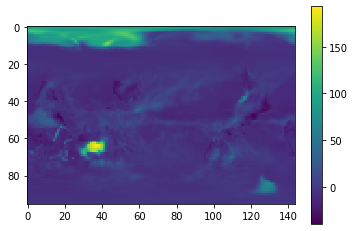

In [56]:
plt.imshow(np.mean(test2,axis=0))
plt.colorbar()

In [205]:
test3 = xr.open_dataset(path_data + '2022_01_19_TRAIN_M4K_TPHYSTND500.nc')

In [216]:
test4 = test3['vars'][:,-1].values

In [228]:
scale_dict['TPHYSTND500']

871587.25

In [217]:
test4.shape

(47177728,)

In [218]:
test5 = np.reshape(test4,(Nt,Nlat,Nlon))

In [219]:
test5.shape

(5759, 64, 128)

In [229]:
test5 *= scale_dict['TPHYSTND500']

In [230]:
MSE_map = np.mean((test5-test2)**2,axis=0)

In [231]:
MSE_map.shape

(64, 128)

In [232]:
VAR_map = np.var(test5,axis=0)

In [233]:
R2 = 1-MSE_map/VAR_map

In [234]:
R2

array([[0.6375874 , 0.65016145, 0.67831147, ..., 0.64215326, 0.64430326,
        0.6511749 ],
       [0.5808109 , 0.5269303 , 0.47454357, ..., 0.6464038 , 0.6146114 ,
        0.57911575],
       [0.71455777, 0.70498335, 0.696025  , ..., 0.74171543, 0.73107255,
        0.7231208 ],
       ...,
       [0.34395885, 0.3660319 , 0.28853852, ..., 0.31259733, 0.38274843,
        0.22285354],
       [0.25589758, 0.19031107, 0.16730809, ..., 0.20241088, 0.3095888 ,
        0.21717024],
       [0.39114374, 0.4111092 , 0.4564824 , ..., 0.30704272, 0.35778612,
        0.31403774]], dtype=float32)

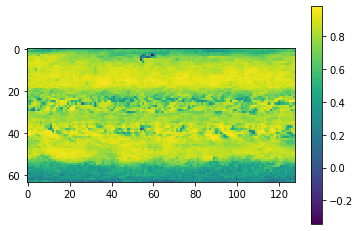

In [235]:
plt.imshow(R2)
plt.colorbar()